## Домашнее задание

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


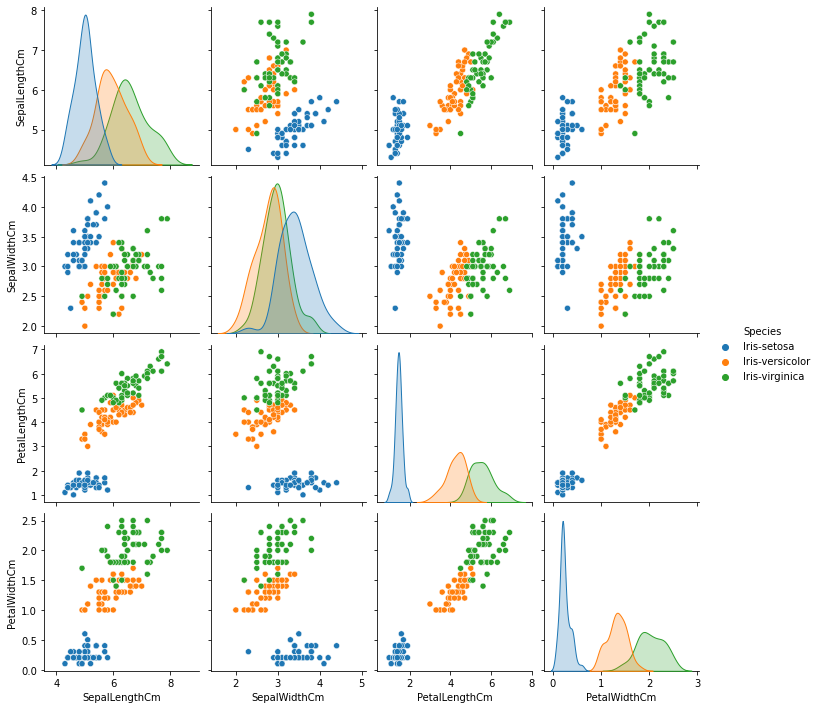

In [3]:

### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("../data/Iris.csv")
print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [4]:
def train_neural_network(X_train, y_train, neuron_numb:int=10, learning_rate:float=0.1, epoch:int=3000):
    """accuracy = (1 - error) * 100"""

    # присваевание случайных весов
    w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, 3 выхода
    w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

    # скорость обучения (learning rate)
    learning_rate = 0.1

    # массив для ошибок, чтобы потом построить график
    errors = []

    # процесс обучения
    for i in range(epoch):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
        layer2_delta = layer2_error * sigmoid_deriv(layer2)
    
        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)
        # коррекция
        w1 += layer1.T.dot(layer2_delta) * learning_rate
        w0 += layer0.T.dot(layer1_delta) * learning_rate
        # метрика модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
    
    return layer2, w0, w1, errors, accuracy


def get_test_res(X_test, y_test, w0, w1):
    # прямое распространение(feed forward)
    layer0_t = X_test
    layer1_t = sigmoid(np.dot(layer0_t, w0))
    layer2_t = sigmoid(np.dot(layer1_t, w1))
    layer2_error_t = y_test - layer2_t
    # метрика модели
    error_t = np.mean(np.abs(layer2_error_t))
    accuracy_t = (1 - error_t) * 100 
    return layer2_t, error_t, accuracy_t

In [5]:
param_dict = {'neuron_numb':[1, 5, 10, 20, 50, 100],
              'learning_rate':[0.1],#[0.001, 0.005, 0.01, 0.05, 0.1, 1],
              'epoch':[1000, 3000, 5000, 10000, 50000, 100000]
             }

In [6]:
%%time
neuron_numbs = []
learning_rates = []
epochs  = []

layers2 = []
w0s = []
w1s = []
errorss = []
accuracys = []

layers2_t = [] 
errors_t = [] 
accuracys_t = []

for numb in param_dict['neuron_numb']:
    for l_rate in param_dict['learning_rate']:
        for epoch in param_dict['epoch']:
            neuron_numbs.append(numb)
            learning_rates.append(l_rate)
            epochs.append(epoch)
            layer2, w0, w1, errors, accuracy = train_neural_network(X_train, y_train, neuron_numb=numb, learning_rate=l_rate, epoch=epoch)
            layers2.append(layer2)
            w0s.append(w0)
            w1s.append(w1)
            errorss.append(errors)
            accuracys.append(accuracy)
            layer2_t, error_t, accuracy_t = get_test_res(X_test, y_test, w0, w1)
            layers2_t.append(layer2_t)
            errors_t.append(error_t)
            accuracys_t.append(accuracy_t)
            
results = pd.DataFrame({'neuron_numb': neuron_numbs,
                        'learning_rate': learning_rates,
                        'epoch': epochs,
                        'layer2': layers2,
                        'w0': w0s,
                        'w1': w1s,
                        'errors': errorss,
                        'accuracy_train': accuracys,
                        'layer2_test': layers2_t,
                        'errors_test': errors_t,
                        'accuracy_test': accuracys_t
                       })

CPU times: user 4min 19s, sys: 4.24 s, total: 4min 23s
Wall time: 2min 18s


In [7]:
results_sort = results.sort_values('accuracy_test', ascending=False)
results_sort

,neuron_numb,learning_rate,epoch,layer2,w0,w1,errors,accuracy_train,layer2_test,errors_test,accuracy_test
23,20,0.1,100000,"[[1.3440752016331176e-06, 0.9999993868986701, ...","[[-0.4107674849762548, -7.8016060212355605, 23...","[[0.8627321834851522, -2.145793632500364, -2.4...","[0.39969672558358127, 0.39638083318917144, 0.4...",98.984135,"[[0.9990948465758068, 7.410296555913144e-38, 0...",0.006864,99.313618
29,50,0.1,100000,"[[3.241267907545619e-09, 0.9999998954014776, 4...","[[-0.7752648186121661, -1.171759138453289, 2.7...","[[-0.16659235263060837, -2.066179712196763, -1...","[0.5199305766183329, 0.3461441728291481, 0.394...",98.944413,"[[0.9990759740527997, 6.129926561548665e-43, 0...",0.013871,98.612886
10,5,0.1,50000,"[[1.7692277521193368e-06, 0.9999986715349247, ...","[[5.220199163232296, -2.4512559884041485, -33....","[[-1.9767935083454107, -8.78994362525613, 1.77...","[0.49271285632341566, 0.4546032022573152, 0.44...",97.682438,"[[0.9972925568888124, 8.100832875710283e-12, 0...",0.014673,98.532721
16,10,0.1,50000,"[[5.630440258134475e-07, 0.9999998493563298, 3...","[[-2.464497232447152, 14.64043657778156, -5.34...","[[-4.174106032040257, 2.1024853412728985, -5.5...","[0.5750277573732078, 0.4652021396368118, 0.442...",97.652946,"[[0.9966982150404179, 9.84913640462881e-20, 0....",0.015184,98.481559
17,10,0.1,100000,"[[6.624873939663387e-07, 0.9999999977432794, 7...","[[-2.3840425245120818, -1.9001887892406386, -1...","[[-2.461940065649553, 0.7629903652426904, 0.27...","[0.43307338673632084, 0.4116040364577281, 0.43...",97.888474,"[[0.9985623648069617, 2.2079960971593683e-21, ...",0.015482,98.451829
21,20,0.1,10000,"[[2.4787784712992033e-05, 0.9986348863636797, ...","[[-2.854240836612733, 2.077468279897082, 1.968...","[[-2.2168415402003236, 2.6150185307459304, -0....","[0.554534255459875, 0.395156883853747, 0.39244...",96.581251,"[[0.9943373323525825, 2.9238489093298885e-15, ...",0.016489,98.351074
9,5,0.1,10000,"[[2.2761018348324106e-05, 0.9989696344915553, ...","[[1.118192584855188, 1.7741890092778574, -8.91...","[[-1.7683838812972286, -2.751946983341943, 0.6...","[0.4916573474335625, 0.44695837779317155, 0.43...",96.516802,"[[0.9918703291269698, 1.959608045370828e-09, 0...",0.016972,98.302821
35,100,0.1,100000,"[[1.004117891869816e-07, 0.9999998141621612, 7...","[[3.0766265192865276, 0.4459793988733029, -7.1...","[[0.9850717540723661, -5.6502361002985335, -1....","[0.5743563194405281, 0.3418166367239468, 0.398...",98.604674,"[[0.9988989930850138, 5.8885580994131e-52, 0.0...",0.019241,98.075938
14,10,0.1,5000,"[[1.8988427969552417e-05, 0.9924253989922204, ...","[[-8.277527220547178, 1.3250916501871837, -1.2...","[[-5.595573598253957, 8.469893123634074, -11.9...","[0.5205331029086848, 0.4044803735648233, 0.426...",96.078500,"[[0.9944388543679678, 1.2159981783851252e-12, ...",0.021739,97.826131
20,20,0.1,5000,"[[2.8446970568317398e-05, 0.9949107439456362, ...","[[1.7755935513624608, 6.826277127157481, -5.89...","[[4.216882560857912, -3.6250673315598263, -14....","[0.5389725779630324, 0.36800042063976285, 0.42...",96.070475,"[[0.9941675901705807, 9.148859416009799e-14, 0...",0.022656,97.734420


In [8]:
res = results[['neuron_numb', 'learning_rate', 'epoch', 'accuracy_train', 'accuracy_test']]
res

,neuron_numb,learning_rate,epoch,accuracy_train,accuracy_test
0,1,0.1,1000,65.976205,58.627597
1,1,0.1,3000,67.715689,59.765362
2,1,0.1,5000,68.199469,60.114255
3,1,0.1,10000,68.754090,60.454509
4,1,0.1,50000,69.757446,60.892722
5,1,0.1,100000,70.100978,61.072133
6,5,0.1,1000,93.866351,95.056057
7,5,0.1,3000,95.909135,96.602554
8,5,0.1,5000,96.423854,96.910009
9,5,0.1,10000,96.516802,98.302821


In [9]:
res.loc[res['epoch']==5000]

,neuron_numb,learning_rate,epoch,accuracy_train,accuracy_test
2,1,0.1,5000,68.199469,60.114255
8,5,0.1,5000,96.423854,96.910009
14,10,0.1,5000,96.078500,97.826131
20,20,0.1,5000,96.070475,97.734420
26,50,0.1,5000,96.049818,97.665926
32,100,0.1,5000,66.666666,66.666666


In [10]:
def show_plot_res(df, iter_param='epoch', accurasy_param='accuracy_train'):
    if iter_param == 'epoch':
        show_param = 'neuron_numb'
    elif iter_param == 'neuron_numb':
        show_param = 'epoch'
    uniq_list_iter_param = df[iter_param].unique()
    
    for param in uniq_list_iter_param:
        _ = df.loc[df[iter_param]==param]
        plt.plot(_[show_param], _[accurasy_param], 'o-', label=show_param)
        plt.legend(loc="lower right")
        plt.grid(color="lightgrey")
        plt.title(f'Сравнение зависимостей {accurasy_param} от {show_param} при {iter_param}={param}')

        plt.show()

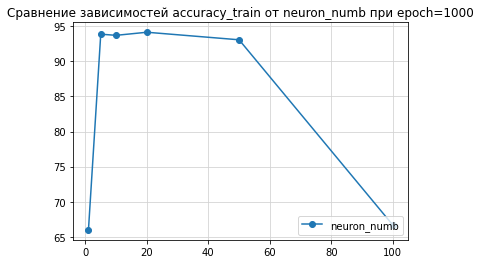

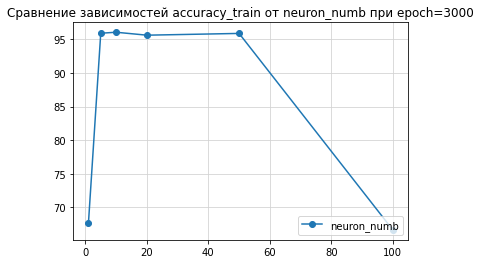

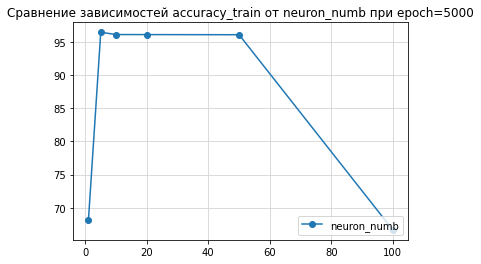

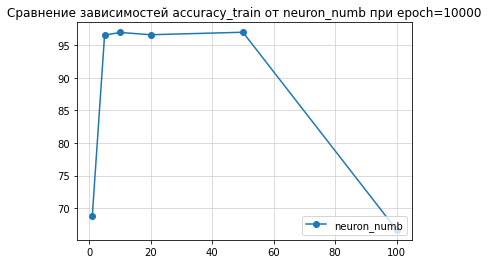

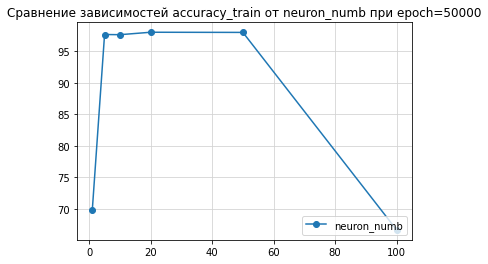

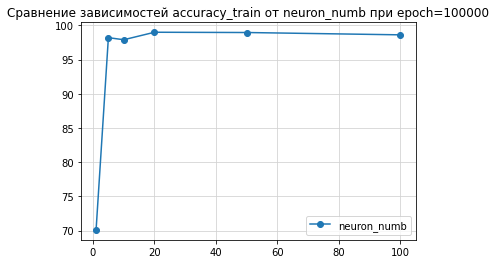

In [11]:
show_plot_res(res, iter_param='epoch', accurasy_param='accuracy_train')

## Для 5, 10, 20, 50 нейронов зависимость наблюдается слабо, для 1 нейрона падение качества, а при количестве нейронов 100 наблюдается падение качества при количестве эпох (1000, 3000, 5000, 10000, 50000),а вот для 100 нейронов при количестве эпох 100000 качество на уровне  качества для количества нейронов от 5-50

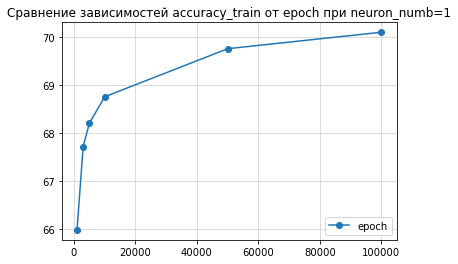

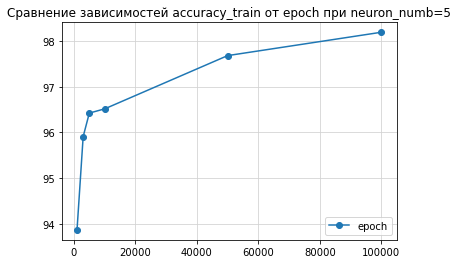

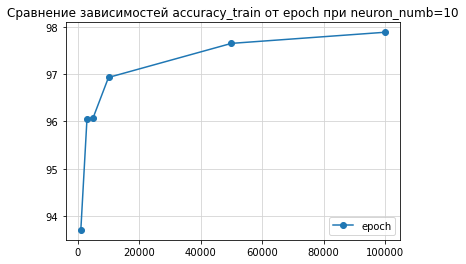

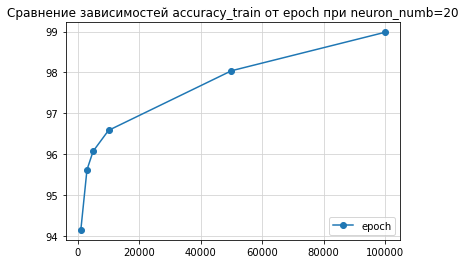

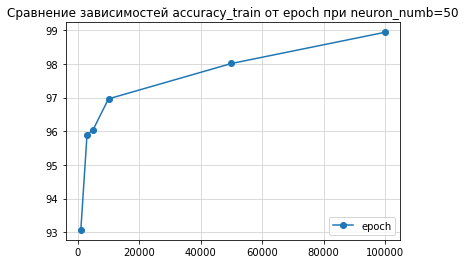

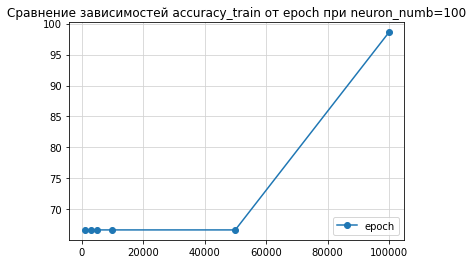

In [12]:
show_plot_res(res, iter_param='neuron_numb', accurasy_param='accuracy_train')

## Качество метрики прямо пропорцианально зависит от количества эпох

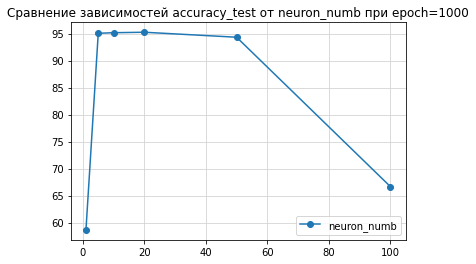

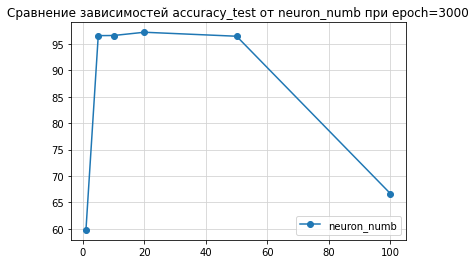

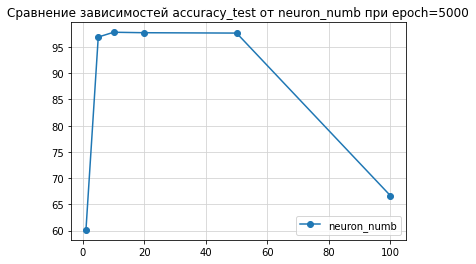

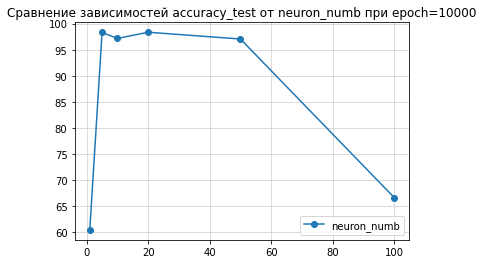

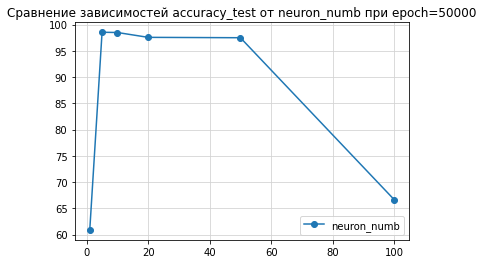

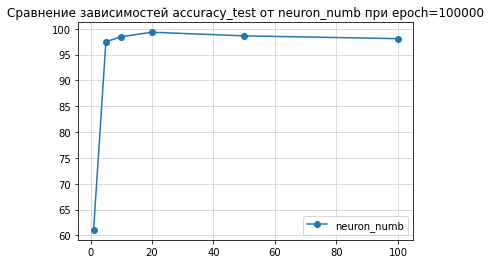

In [13]:
show_plot_res(res, iter_param='epoch', accurasy_param='accuracy_test')

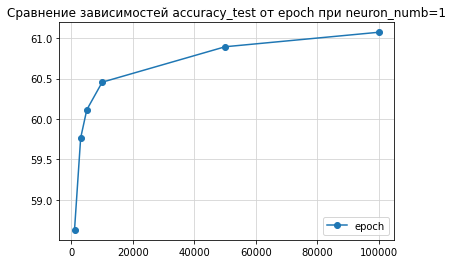

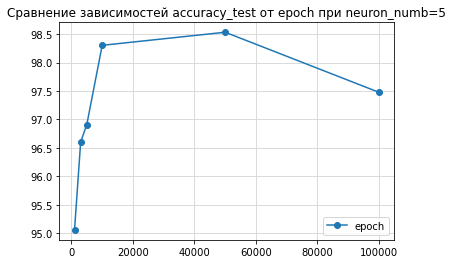

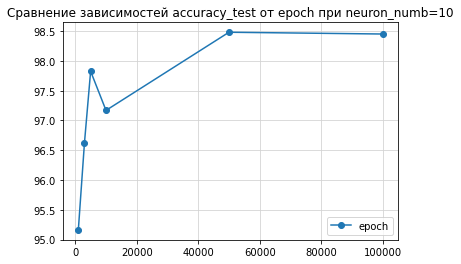

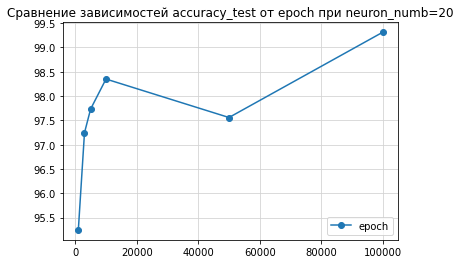

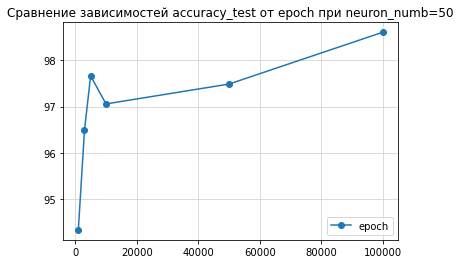

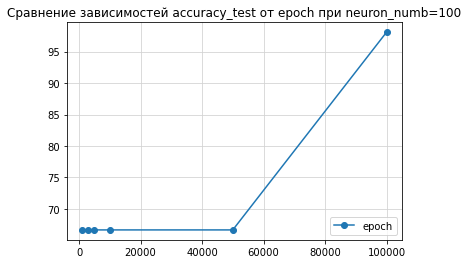

In [14]:
show_plot_res(res, iter_param='neuron_numb', accurasy_param='accuracy_test')

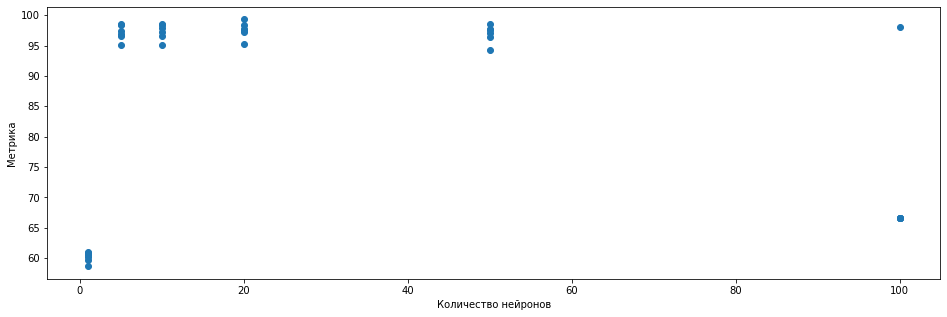

In [15]:
plt.figure(figsize = (16,5))
plt.scatter(res['neuron_numb'], res['accuracy_test'])
plt.xlabel('Количество нейронов')
plt.ylabel('Метрика')
plt.show()

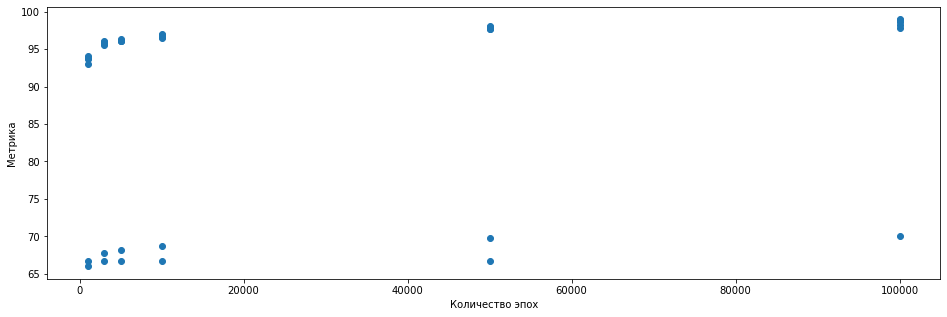

In [16]:
plt.figure(figsize = (16,5))
plt.scatter(res['epoch'], res['accuracy_train'])
plt.xlabel('Количество эпох')
plt.ylabel('Метрика')
plt.show()

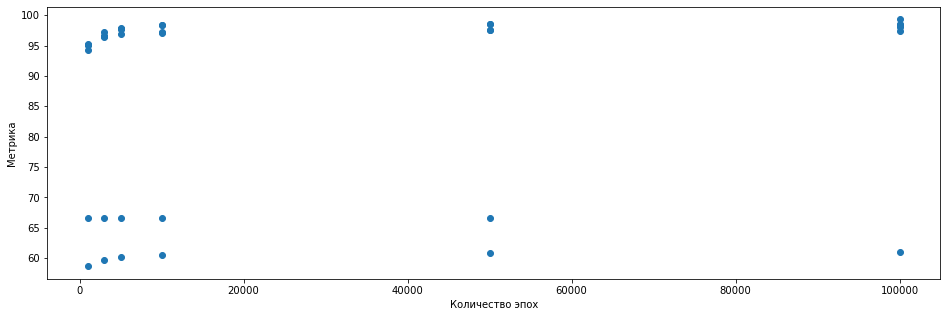

In [17]:
plt.figure(figsize = (16,5))
plt.scatter(res['epoch'], res['accuracy_test'])
plt.xlabel('Количество эпох')
plt.ylabel('Метрика')
plt.show()

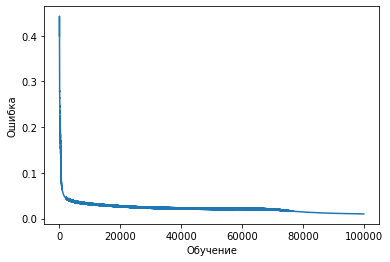

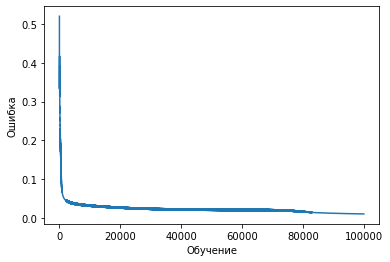

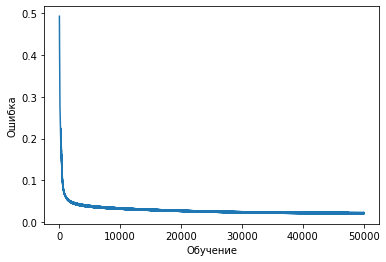

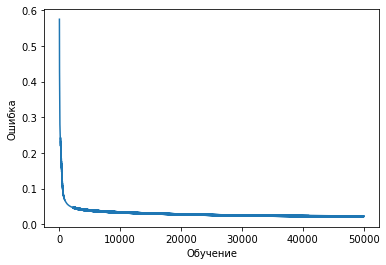

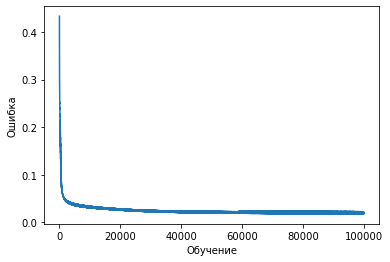

In [18]:

### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения
for error in results_sort['errors'].head():
    plt.plot(error)
    plt.xlabel('Обучение')
    plt.ylabel('Ошибка')
    plt.show() # расскоментируйте, чтобы посмотреть 



## Отсортированый датафрейм по метрике на тесте

In [23]:
res_sort = results_sort[['neuron_numb', 'learning_rate', 'epoch', 'accuracy_train', 'accuracy_test']].sort_values('accuracy_test', ascending=False)
res_sort

,neuron_numb,learning_rate,epoch,accuracy_train,accuracy_test
23,20,0.1,100000,98.984135,99.313618
29,50,0.1,100000,98.944413,98.612886
10,5,0.1,50000,97.682438,98.532721
16,10,0.1,50000,97.652946,98.481559
17,10,0.1,100000,97.888474,98.451829
21,20,0.1,10000,96.581251,98.351074
9,5,0.1,10000,96.516802,98.302821
35,100,0.1,100000,98.604674,98.075938
14,10,0.1,5000,96.078500,97.826131
20,20,0.1,5000,96.070475,97.734420


## Топ 5 параметров высокого качества 

In [24]:
res_sort.head()

,neuron_numb,learning_rate,epoch,accuracy_train,accuracy_test
23,20,0.1,100000,98.984135,99.313618
29,50,0.1,100000,98.944413,98.612886
10,5,0.1,50000,97.682438,98.532721
16,10,0.1,50000,97.652946,98.481559
17,10,0.1,100000,97.888474,98.451829
